# Rocky Stats - Enterprise Linux Distribution Analysis

This notebook analyzes EPEL and DockerHub data to track Enterprise Linux distribution usage patterns.

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import our custom modules
from config import *
from data_utils import *
from plot_utils import *

# Ensure output directory exists
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)

## Data Loading and Preprocessing

In [2]:
# Load EPEL data
epel_df = load_epel_data()

# Load DockerHub data (currently disabled)
# dh_df = load_dockerhub_data()

print(f"EPEL data loaded: {len(epel_df):,} records")
print(f"Date range: {epel_df['week_end'].min()} to {epel_df['week_end'].max()}")

File 'epel.csv' is up to date.
EPEL data loaded: 400,938 records
Date range: 2009-02-22 00:00:00 to 2025-08-10 00:00:00


## Distribution Share Analysis

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution Share', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Share of Instances'>)

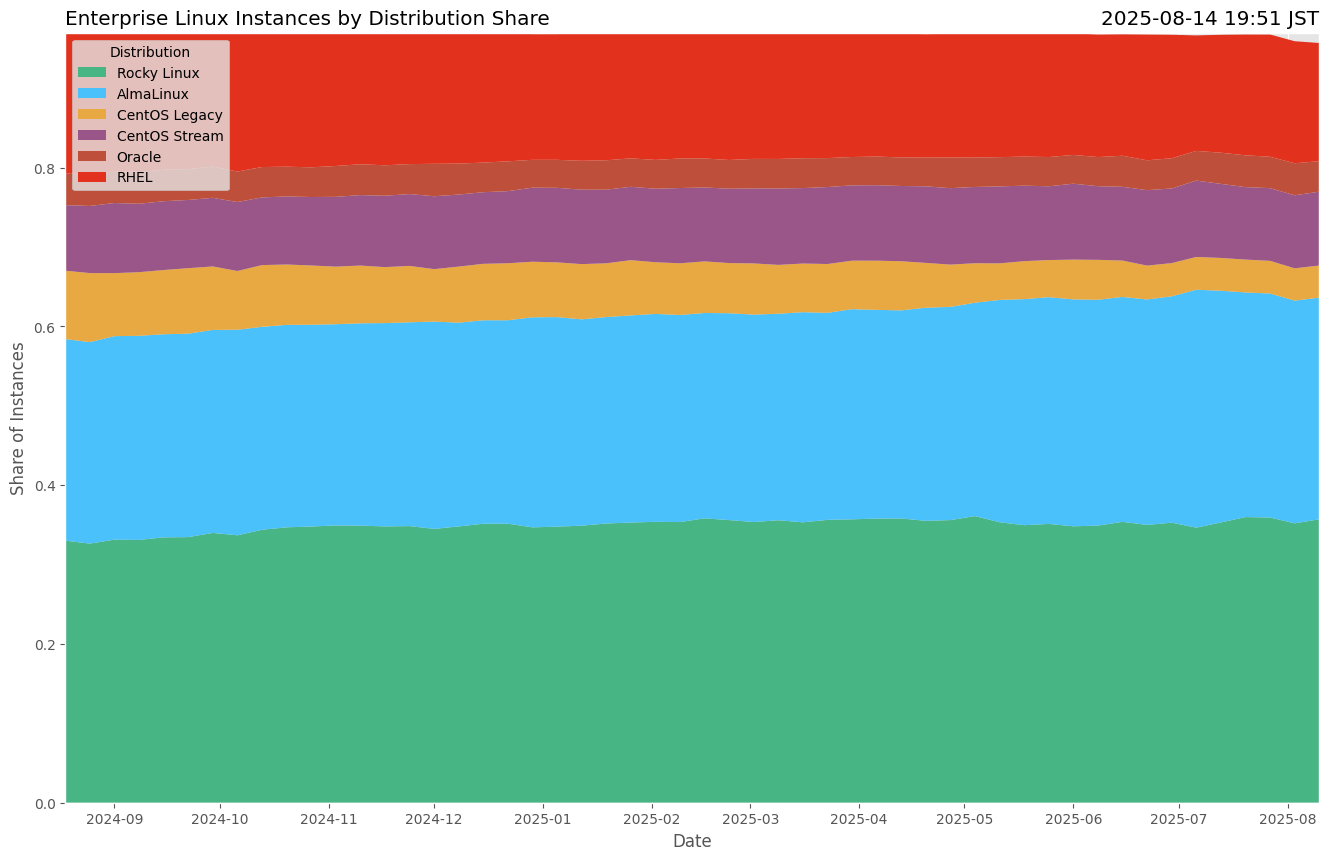

In [3]:
# Enterprise Linux Instances by Distribution Share (Recent)
df = filter_by_date(epel_df, STARTDATE)
pt = create_pivot_table(df, index='week_end', columns='os_name')
pt = add_total_column(pt)

create_distribution_share_plot(
    pt, 
    'Enterprise Linux Instances by Distribution Share',
    'el89_by_distro_total_share_area'
)

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

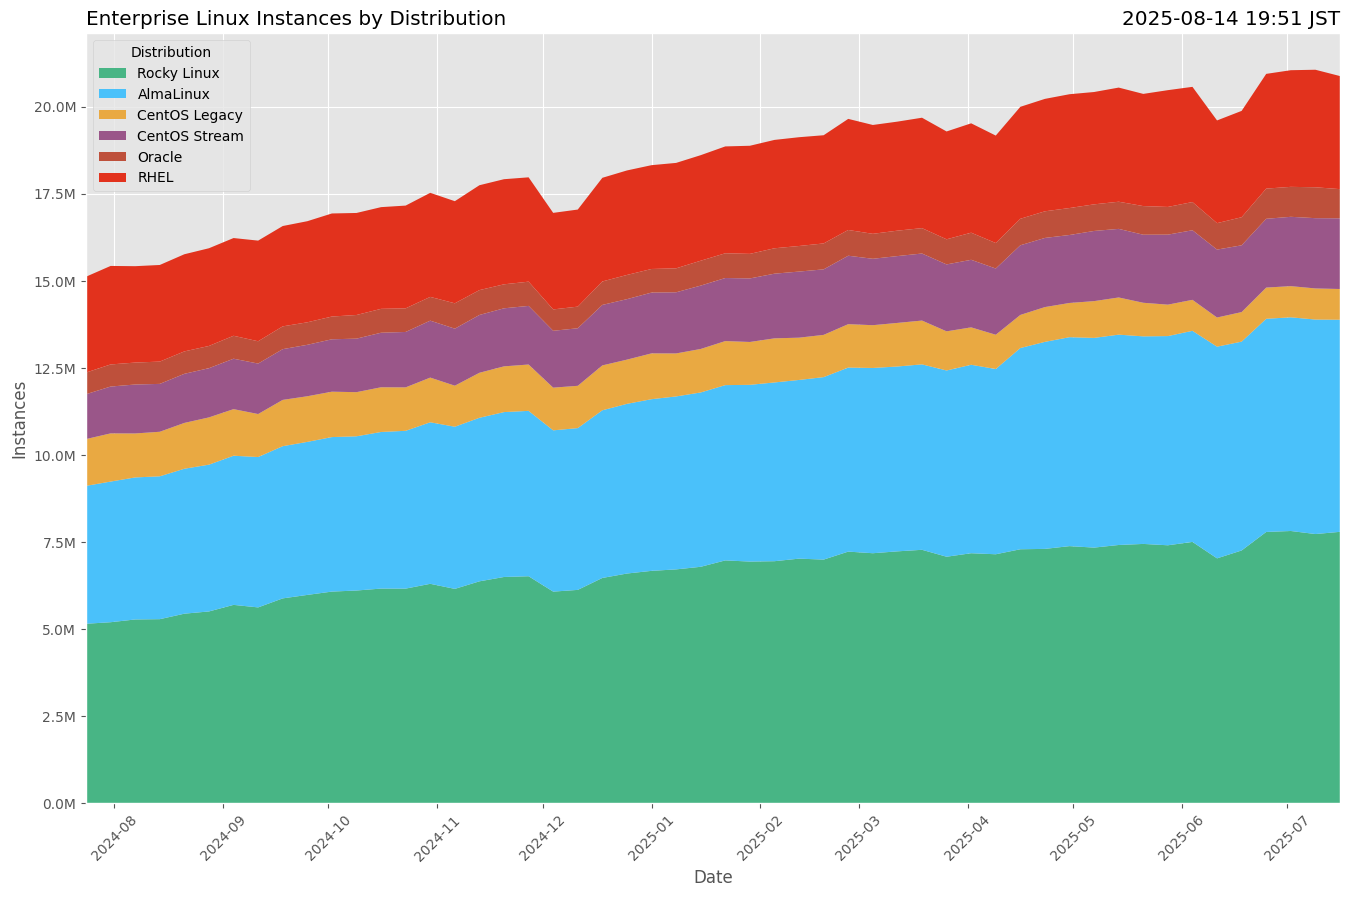

In [4]:
# Enterprise Linux Instances by Distribution (Recent)
df = filter_by_date(epel_df, STARTDATE)
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_distribution_total_plot(
    pt,
    'Enterprise Linux Instances by Distribution',
    'el89_by_distro_total_area'
)

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution Share (System Age > 1 Week)', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Share'>)

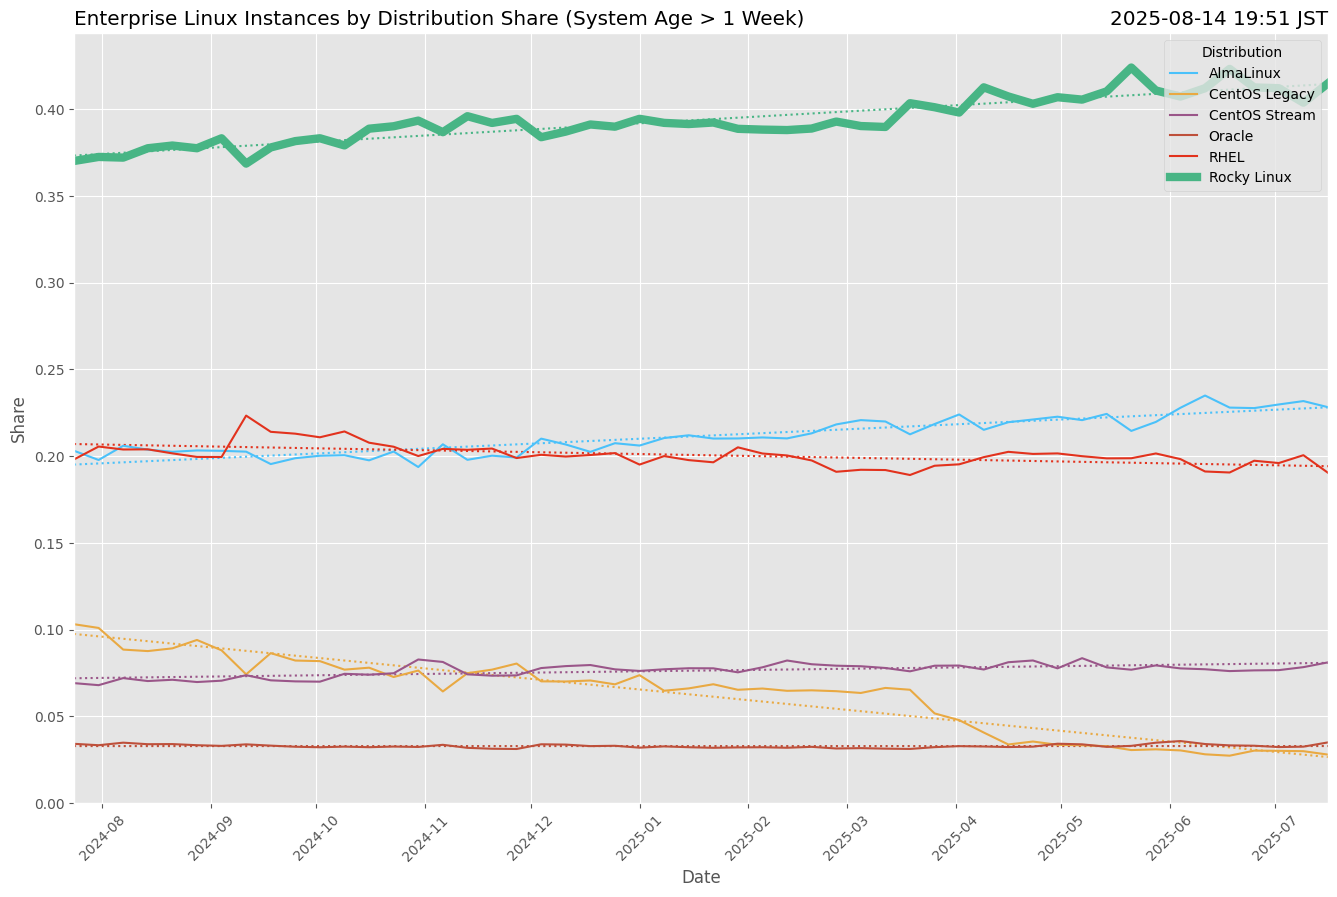

In [5]:
# Enterprise Linux Share by Distribution (Long-term, System Age > 1 Week)
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_share_line_plot(
    pt,
    'Enterprise Linux Instances by Distribution Share (System Age > 1 Week)',
    'el_by_distro_share_line'
)

## Long-term Trend Analysis

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution (System Age > 1 Week, 2 Week Resample)', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

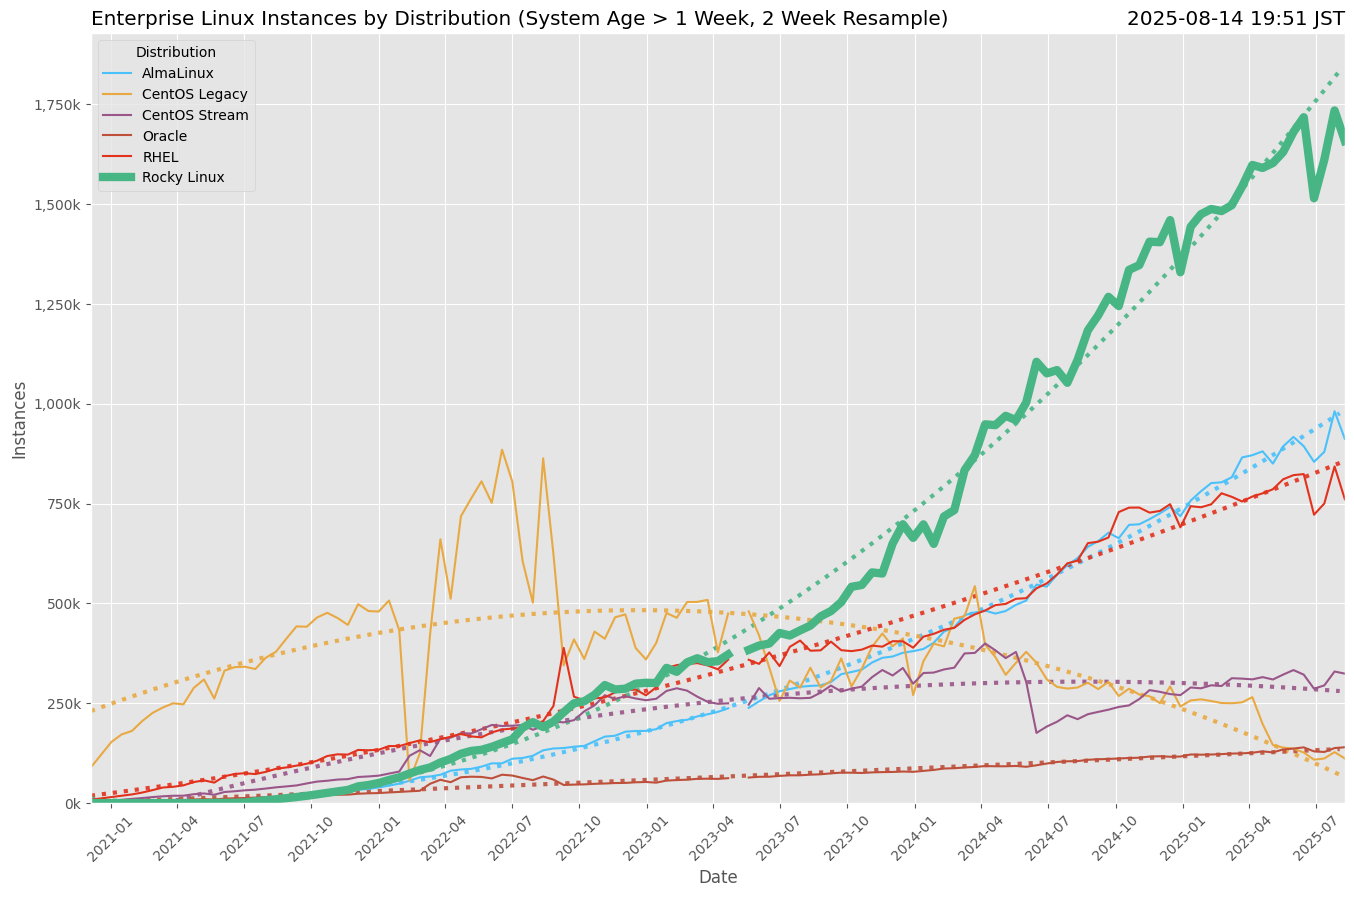

In [6]:
# Enterprise Linux Instances by Distribution (Long-term)
df = filter_by_date(epel_df, STARTDATE_LONG)
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_line_plot_with_trends(
    pt,
    'Enterprise Linux Instances by Distribution (System Age > 1 Week, 2 Week Resample)',
    'el_by_distro_longterm_line',
    poly_degree=2,
    resample='2W'
)

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution (System Age > 1 Week, 2 Week Resample)', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

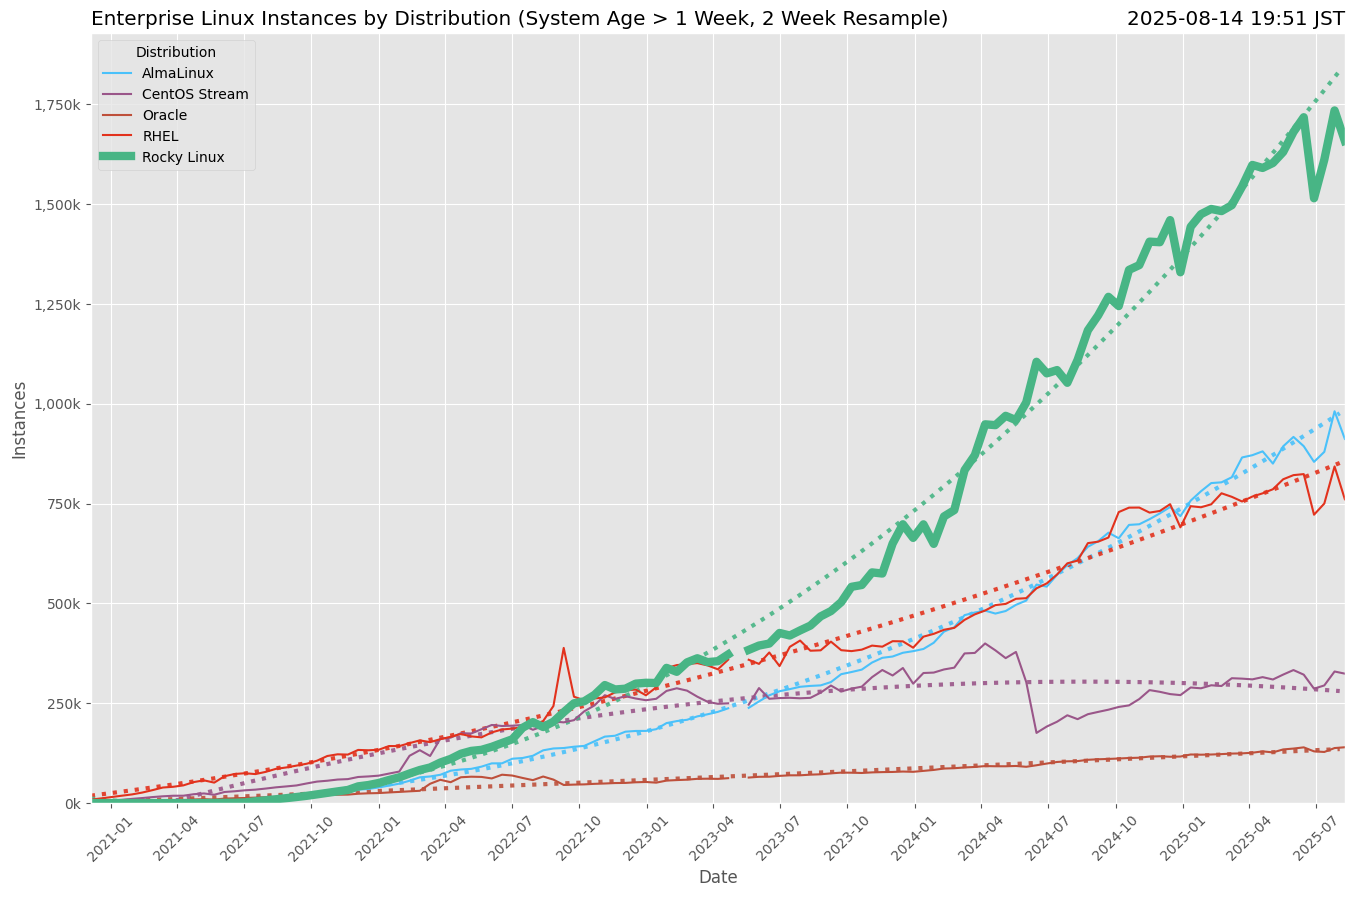

In [7]:
# Enterprise Linux Instances by Distribution (without Legacy CentOS)
df = filter_by_date(epel_df, STARTDATE_LONG)
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name')

# Remove CentOS Linux from the distro list
distro_list = [d for d in DISTROS if d != 'CentOS Linux']

create_line_plot_with_trends(
    pt,
    'Enterprise Linux Instances by Distribution (System Age > 1 Week, 2 Week Resample)',
    'el_by_distro_longterm_line_nocentos',
    distro_list=distro_list,
    poly_degree=2,
    resample='2W'
)

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Potentially Ephemeral Enterprise Linux Instances by Distribution (2 Week Resample)', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

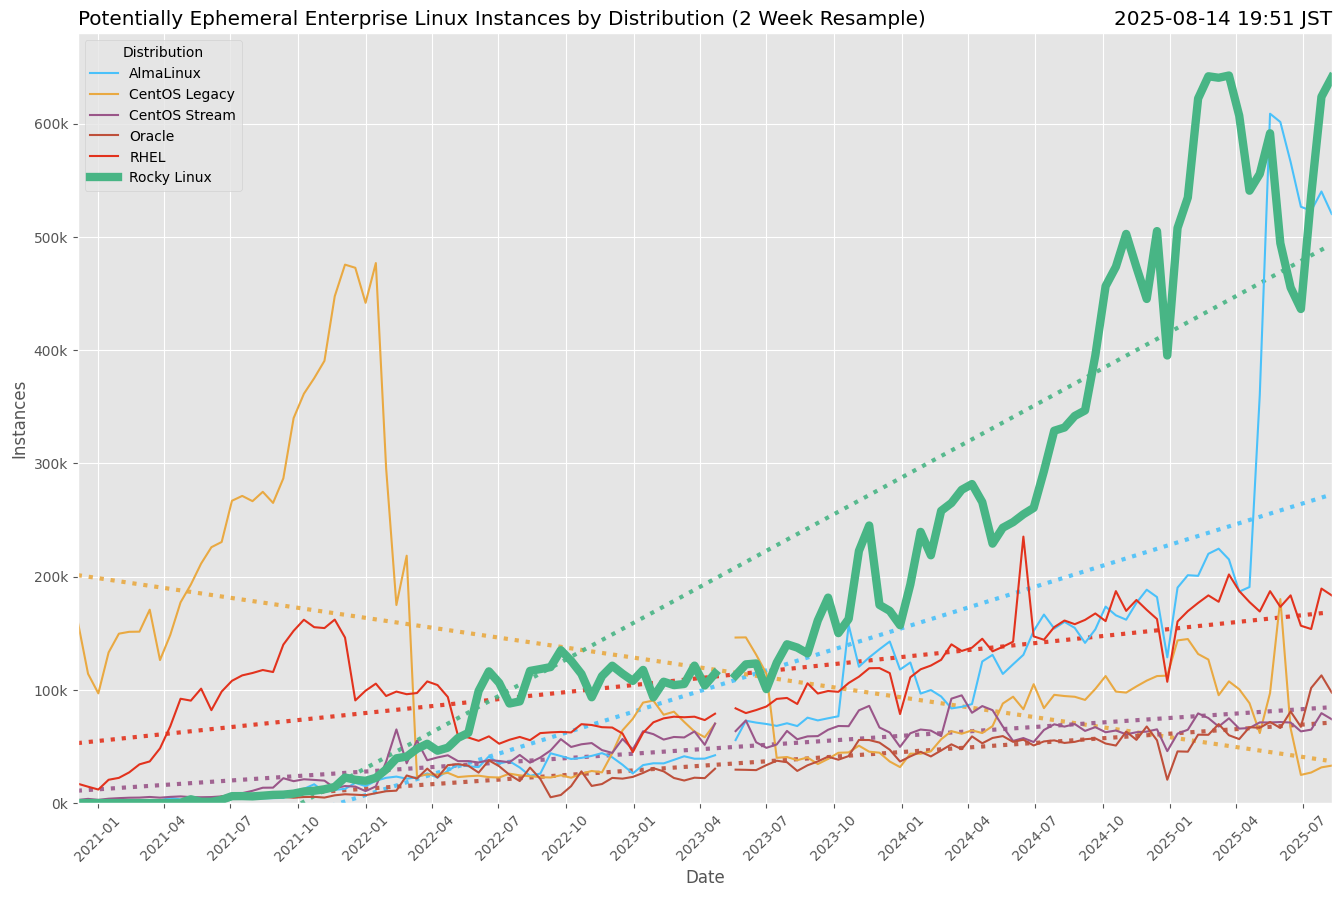

In [8]:
# Potentially Ephemeral Enterprise Linux Instances (Long-term)
df = filter_by_date(epel_df, STARTDATE_LONG)
df = filter_by_system_age(df, 'ephemeral')
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_line_plot_with_trends(
    pt,
    'Potentially Ephemeral Enterprise Linux Instances by Distribution (2 Week Resample)',
    'el_by_distro_ephemeral_longterm_line',
    resample='2W'
)

## Recent Trend Analysis

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by Distribution (System Age > 1 Week)', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

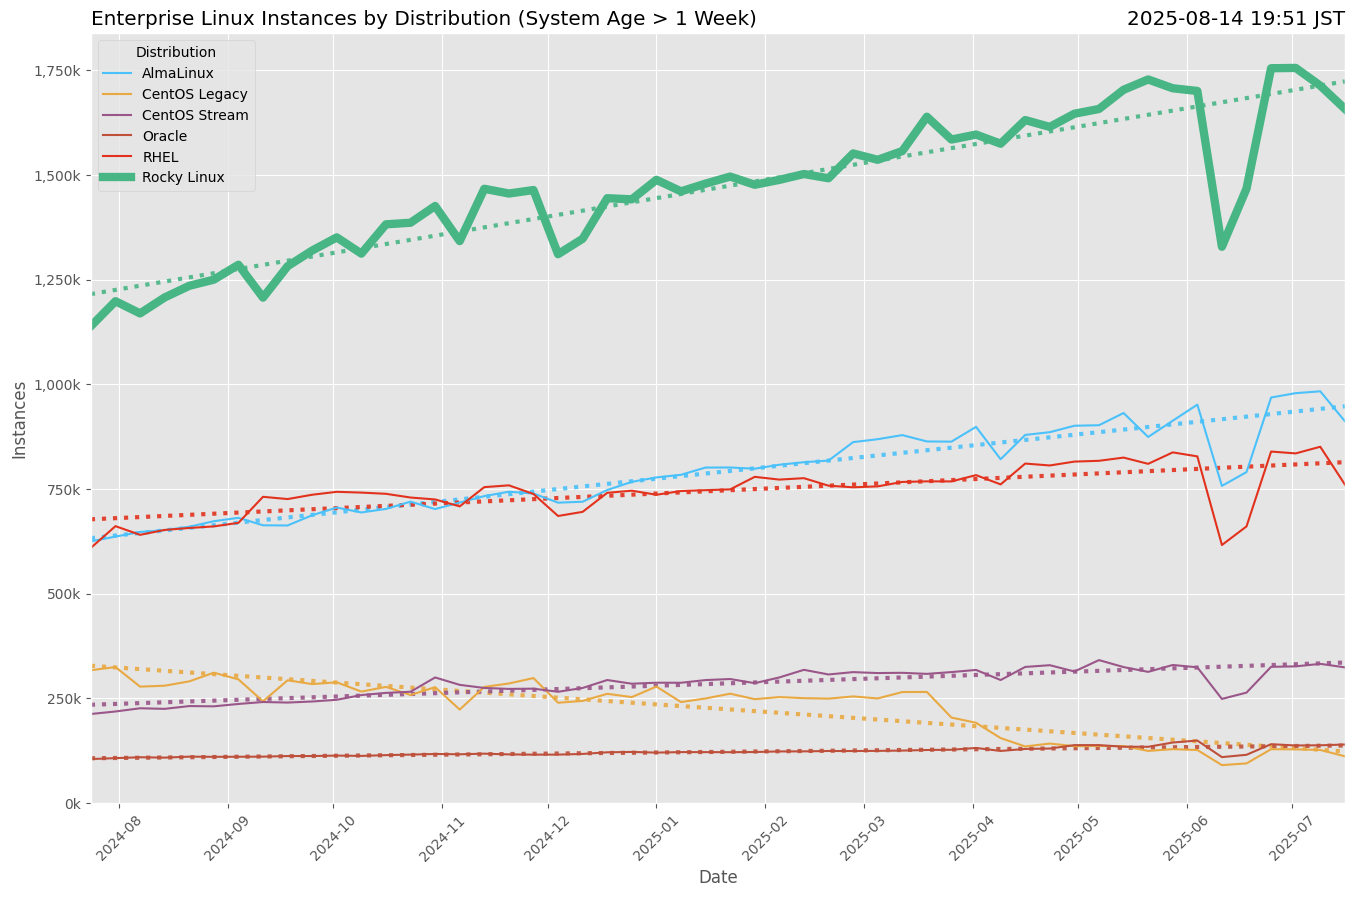

In [9]:
# Enterprise Linux Instances by Distribution (Recent, System Age > 1 Week)
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_line_plot_with_trends(
    pt,
    'Enterprise Linux Instances by Distribution (System Age > 1 Week)',
    'el_by_distro_line',
    poly_degree=1
)

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Potentially Ephemeral Enterprise Linux Instances by Distribution', 'right': '2025-08-14 19:51 JST'}, xlabel='Date', ylabel='Instances'>)

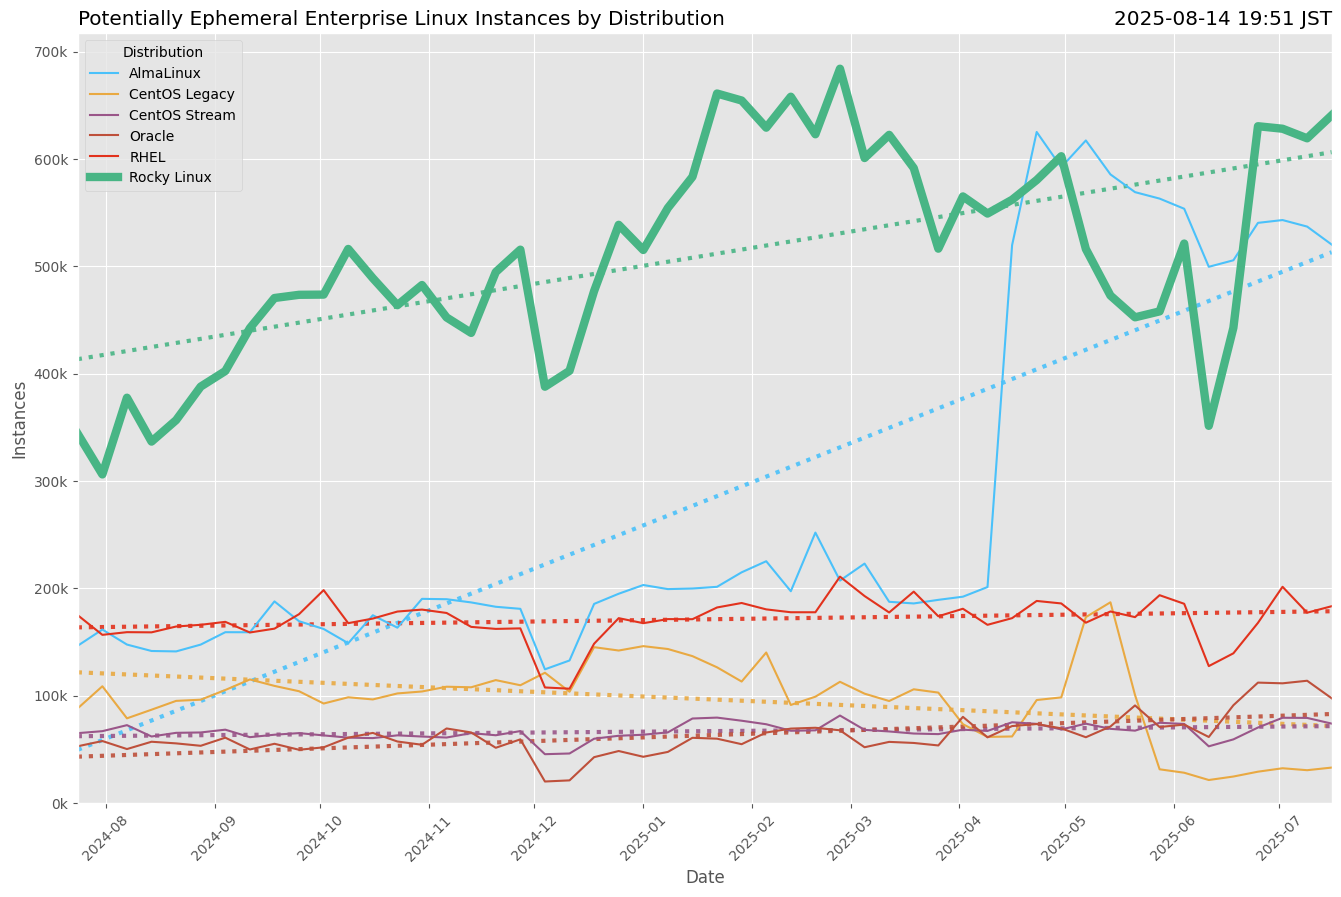

In [10]:
# Potentially Ephemeral Enterprise Linux Instances (Recent)
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_system_age(df, 'ephemeral')
pt = create_pivot_table(df, index='week_end', columns='os_name')

create_line_plot_with_trends(
    pt,
    'Potentially Ephemeral Enterprise Linux Instances by Distribution',
    'el_by_distro_ephemeral_line',
    poly_degree=1
)

## Version-Specific Analysis

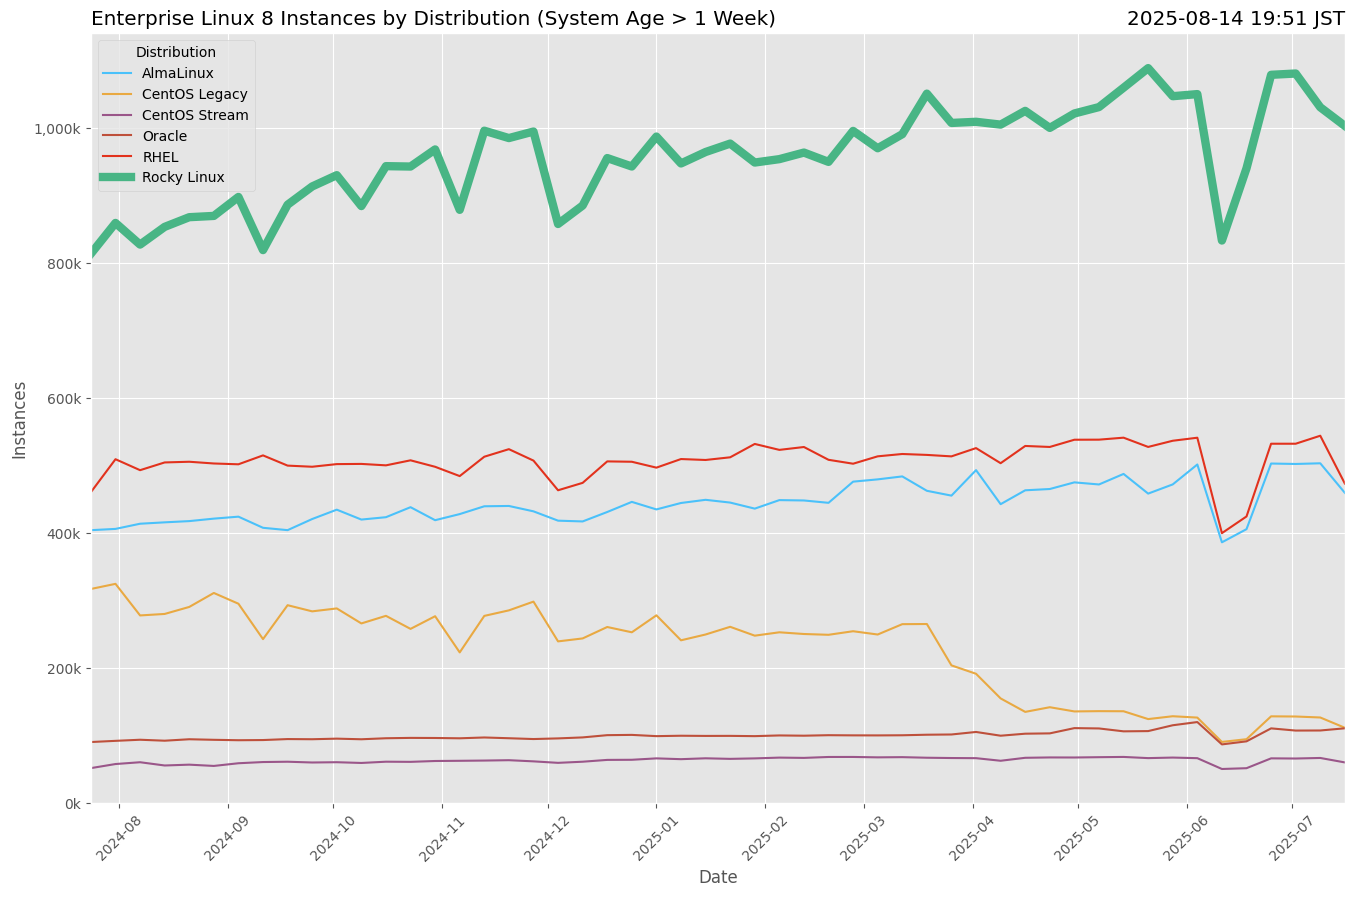

In [11]:
# Enterprise Linux 8 Instances by Distribution
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_repo_tag(df, 'epel-8')
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name', fill_value=None)

fig, ax = setup_plot()
plot_lines_with_emphasis(ax, pt, emphasize='Rocky Linux')
setup_axis_formatting(ax)
add_title_and_timestamp('Enterprise Linux 8 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.ylabel('Instances')
plt.legend(title='Distribution')
save_plot('el8_by_distro_line')

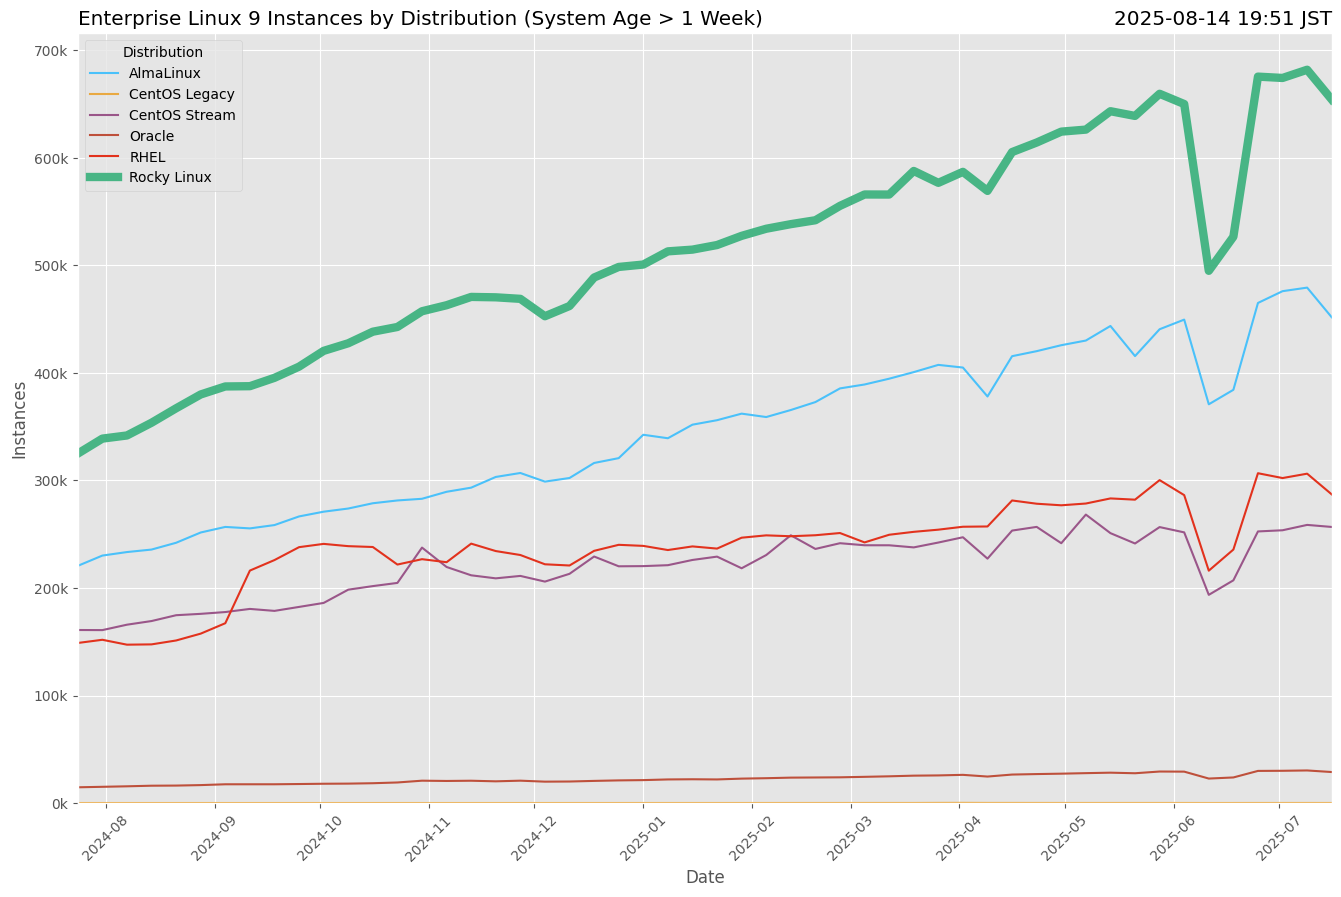

In [12]:
# Enterprise Linux 9 Instances by Distribution
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_repo_tag(df, 'epel-9')
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name', fill_value=None)

fig, ax = setup_plot()
plot_lines_with_emphasis(ax, pt)
setup_axis_formatting(ax)
add_title_and_timestamp('Enterprise Linux 9 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.ylabel('Instances')
plt.legend(title='Distribution')
save_plot('el9_by_distro_line')

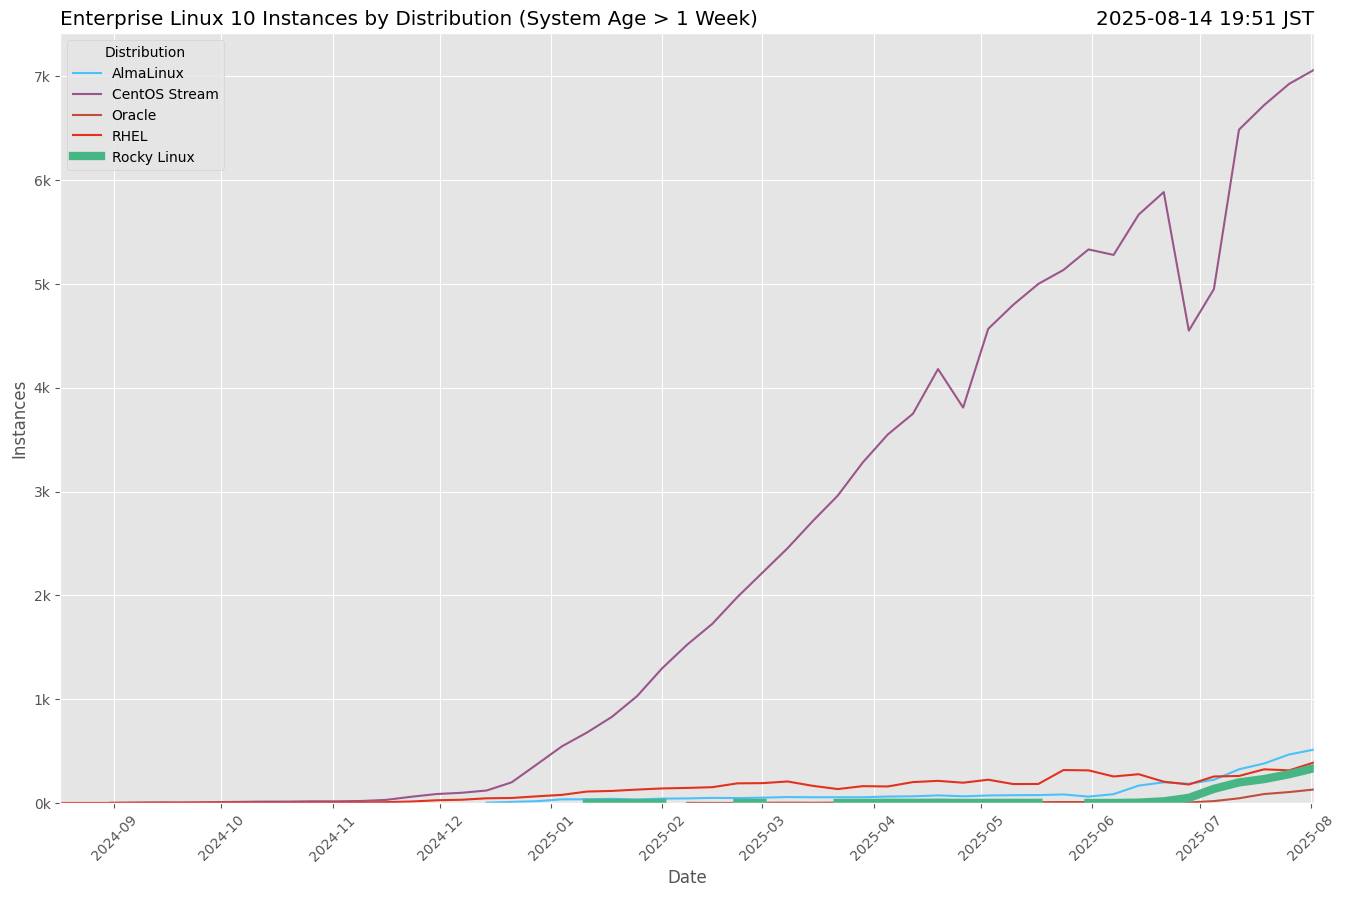

In [13]:
# Enterprise Linux 10 Instances by Distribution
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_repo_tag(df, 'epel-10')
df = filter_by_system_age(df, 'longterm')
pt = create_pivot_table(df, index='week_end', columns='os_name', fill_value=None)

fig, ax = setup_plot()
plot_lines_with_emphasis(ax, pt, distro_list=CURRENT_DISTROS)
setup_axis_formatting(ax)
add_title_and_timestamp('Enterprise Linux 10 Instances by Distribution (System Age > 1 Week)')
plt.xlabel('Date')
plt.ylabel('Instances')
plt.legend(title='Distribution')
save_plot('el10_by_distro_line')

## Architecture Analysis

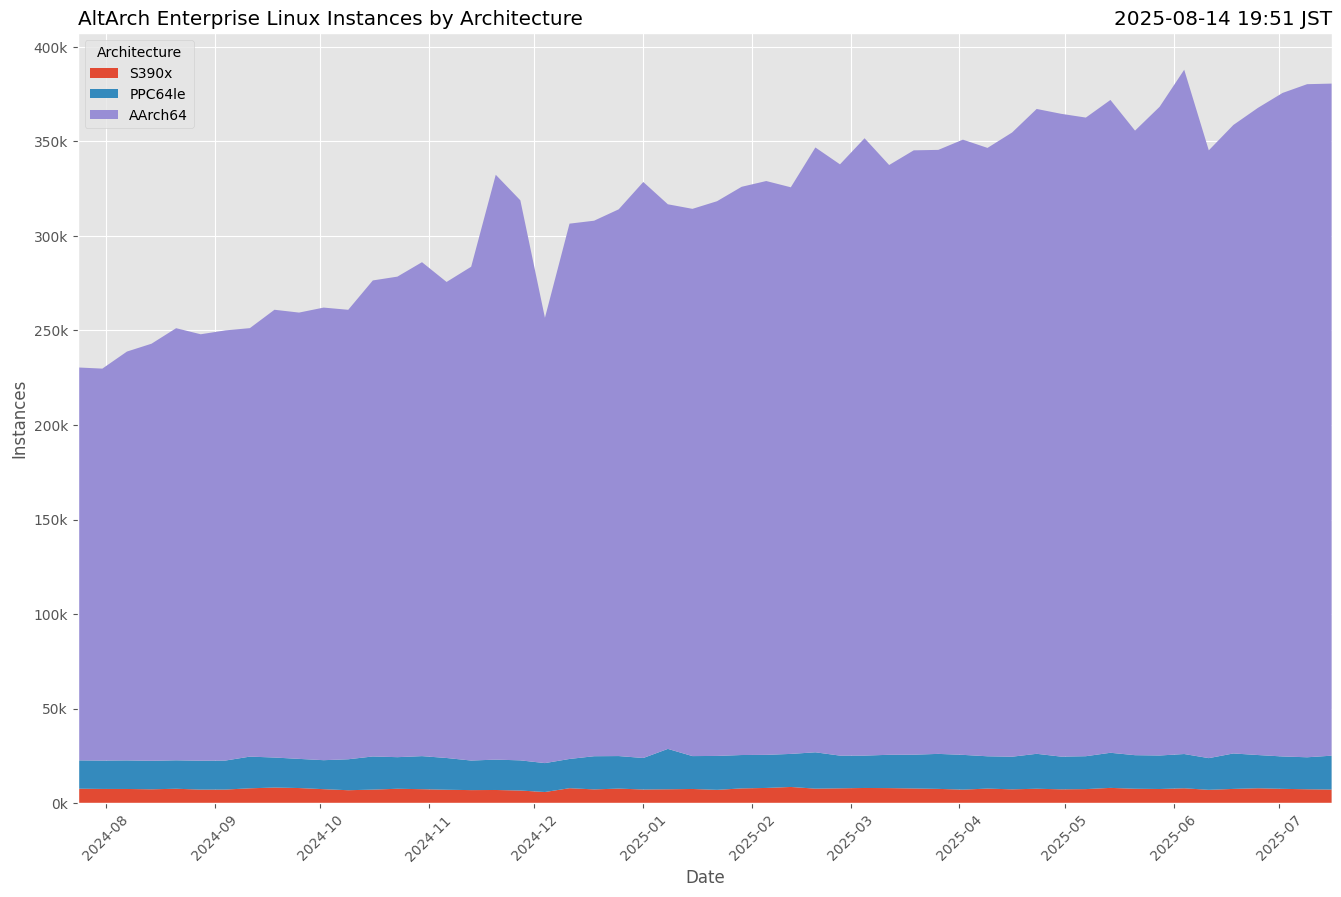

In [14]:
# AltArch Enterprise Linux Instances by Architecture
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_arch(df, 'altarch')
pt = create_pivot_table(df, index='week_end', columns='repo_arch')

fig, ax = setup_plot()
ax.stackplot(pt.index, pt['s390x'], pt['ppc64le'], pt['aarch64'], 
             labels=['S390x', 'PPC64le', 'AArch64'])
setup_axis_formatting(ax)
add_title_and_timestamp('AltArch Enterprise Linux Instances by Architecture')
plt.xlabel('Date')
plt.ylabel('Instances')
plt.legend(title='Architecture', loc='upper left')
save_plot('altarch_by_arch_area')

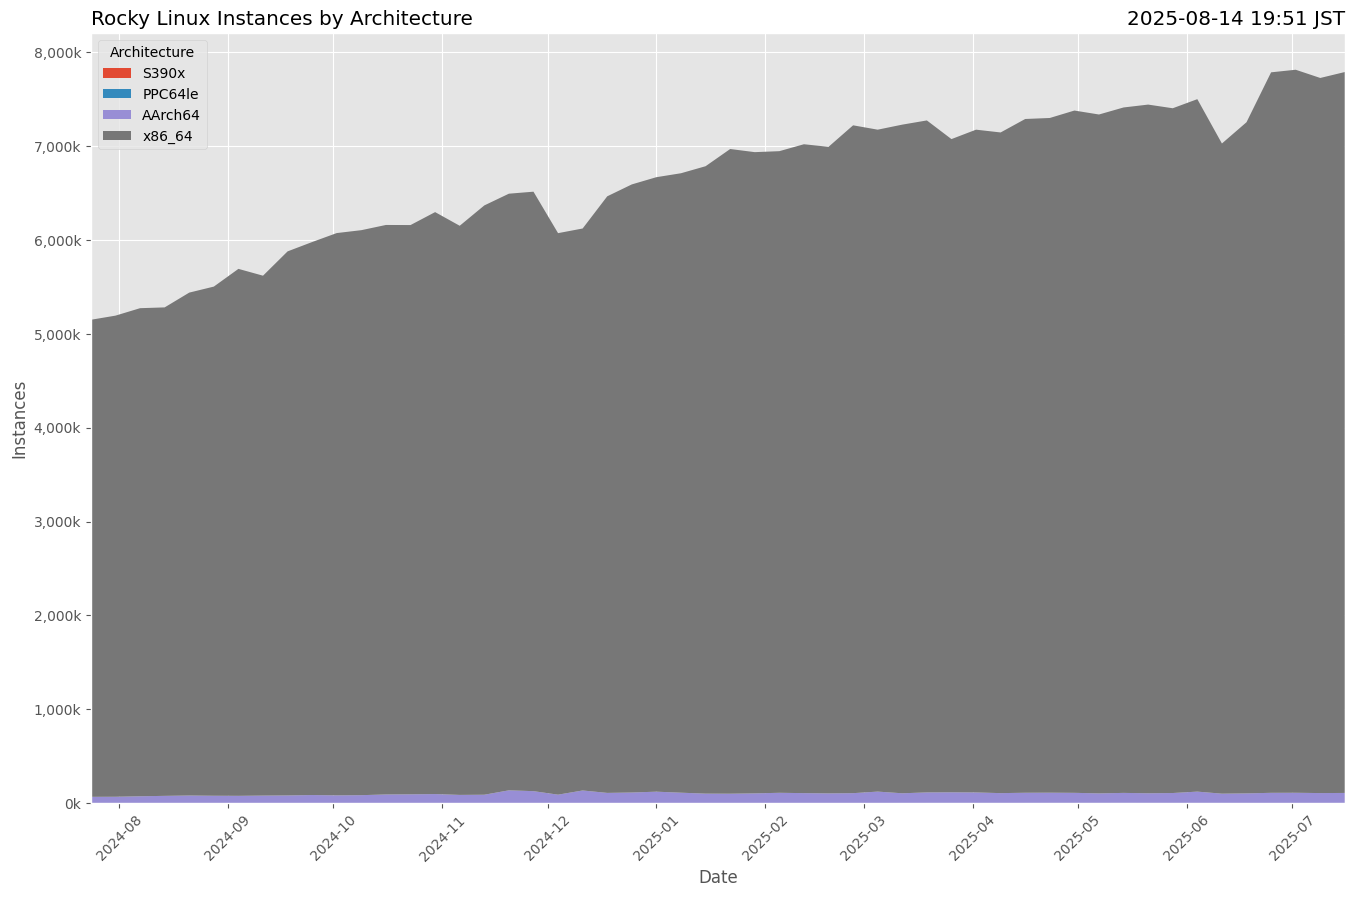

In [15]:
# Rocky Linux Instances by Architecture
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_os_name(df, 'Rocky Linux')
pt = create_pivot_table(df, index='week_end', columns='repo_arch')

fig, ax = setup_plot()
ax.stackplot(pt.index, pt['s390x'], pt['ppc64le'], pt['aarch64'], pt['x86_64'],
             labels=['S390x', 'PPC64le', 'AArch64', 'x86_64'])
setup_axis_formatting(ax)
add_title_and_timestamp('Rocky Linux Instances by Architecture')
plt.xlabel('Date')
plt.ylabel('Instances')
plt.legend(title='Architecture', loc='upper left')
save_plot('rocky_by_arch_area')

## System Age Analysis

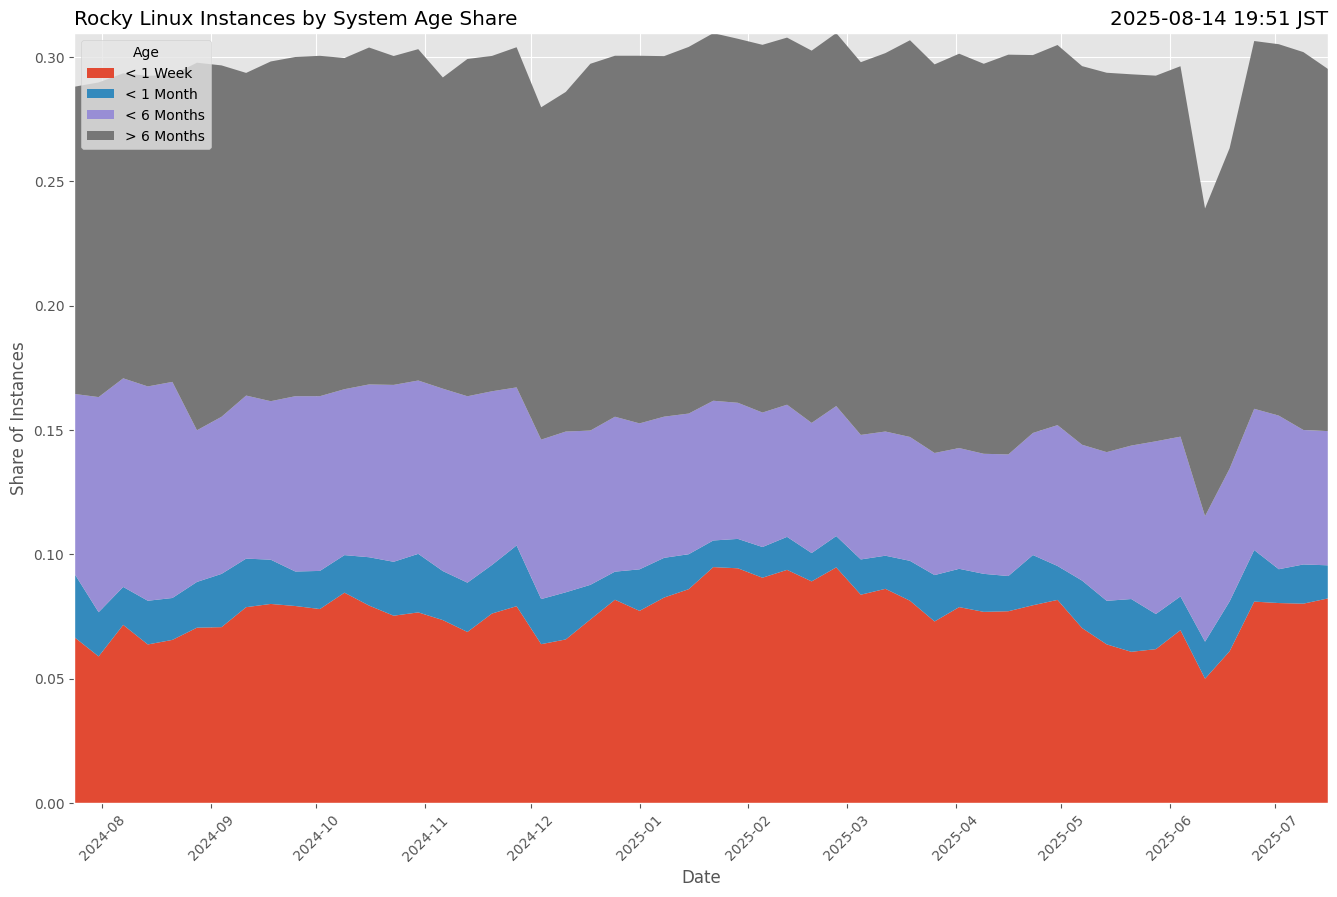

In [16]:
# Rocky Linux Instances by System Age Share
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_os_name(df, 'Rocky Linux')
pt = create_pivot_table(df, index='week_end', columns='sys_age')
pt = add_total_column(pt)

fig, ax = setup_plot()
ax.stackplot(pt.index, pt[1]/pt['total'], pt[2]/pt['total'], 
             pt[3]/pt['total'], pt[4]/pt['total'],
             labels=['< 1 Week', '< 1 Month', '< 6 Months', '> 6 Months'])
setup_dates(ax)
add_title_and_timestamp('Rocky Linux Instances by System Age Share')
plt.xlabel('Date')
plt.ylabel('Share of Instances')
plt.legend(title='Age', loc='upper left')
save_plot('rocky_by_age_share_area')

(<Figure size 1618x1000 with 1 Axes>,
 <Axes: title={'left': 'Enterprise Linux Instances by System Age and Distribution', 'right': '2025-08-14 19:51 JST'}, xlabel='System Age', ylabel='Instances'>)

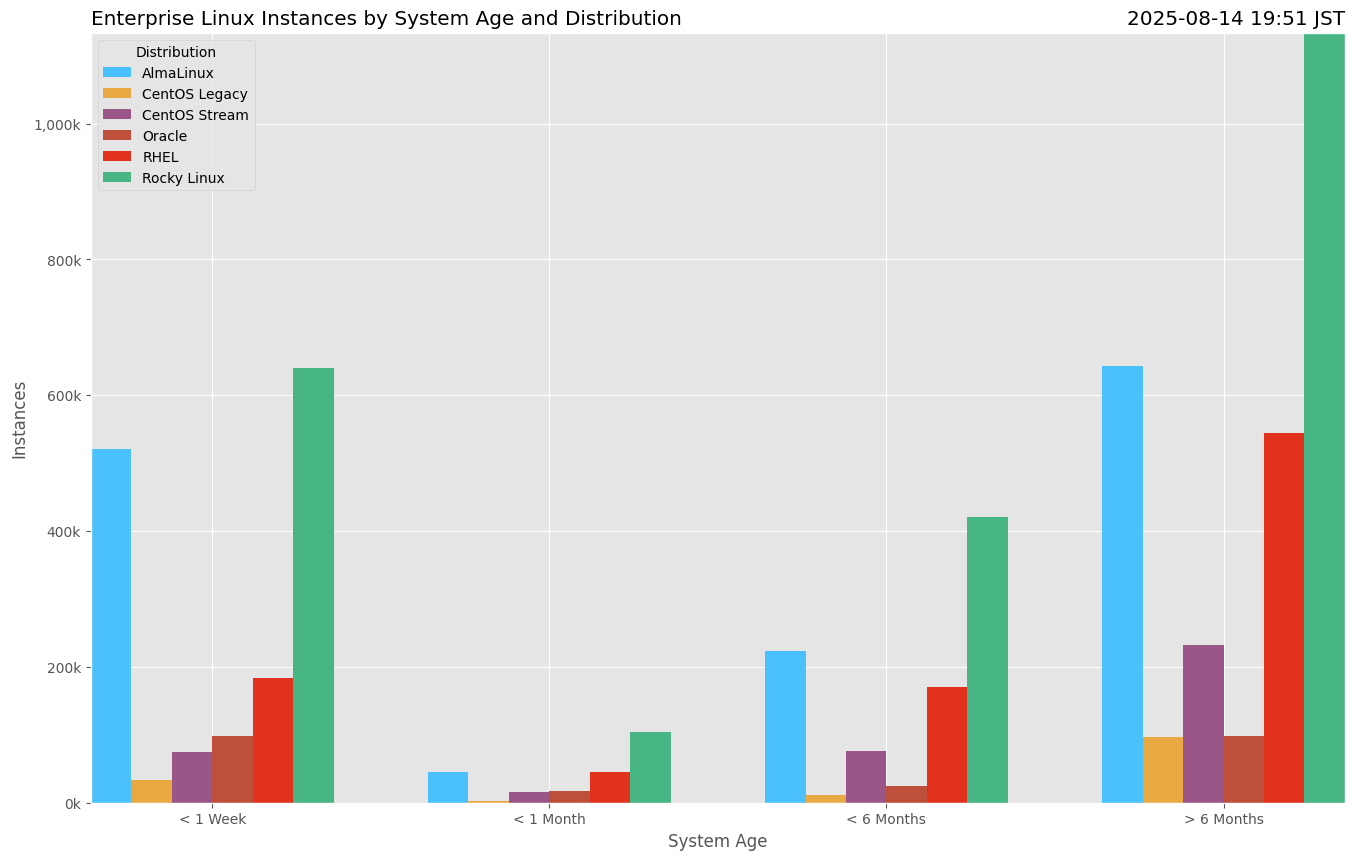

In [17]:
# Enterprise Linux Instances by System Age and Distribution
df = epel_df[epel_df['week_end'] == epel_df['week_end'].max()]
df = df[df['sys_age'] > 0]
pt = create_pivot_table(df, index='sys_age', columns='os_name')

create_bar_plot_by_age(
    pt,
    'Enterprise Linux Instances by System Age and Distribution',
    'el_by_age_distro_bars'
)

## Rocky Linux Version Analysis

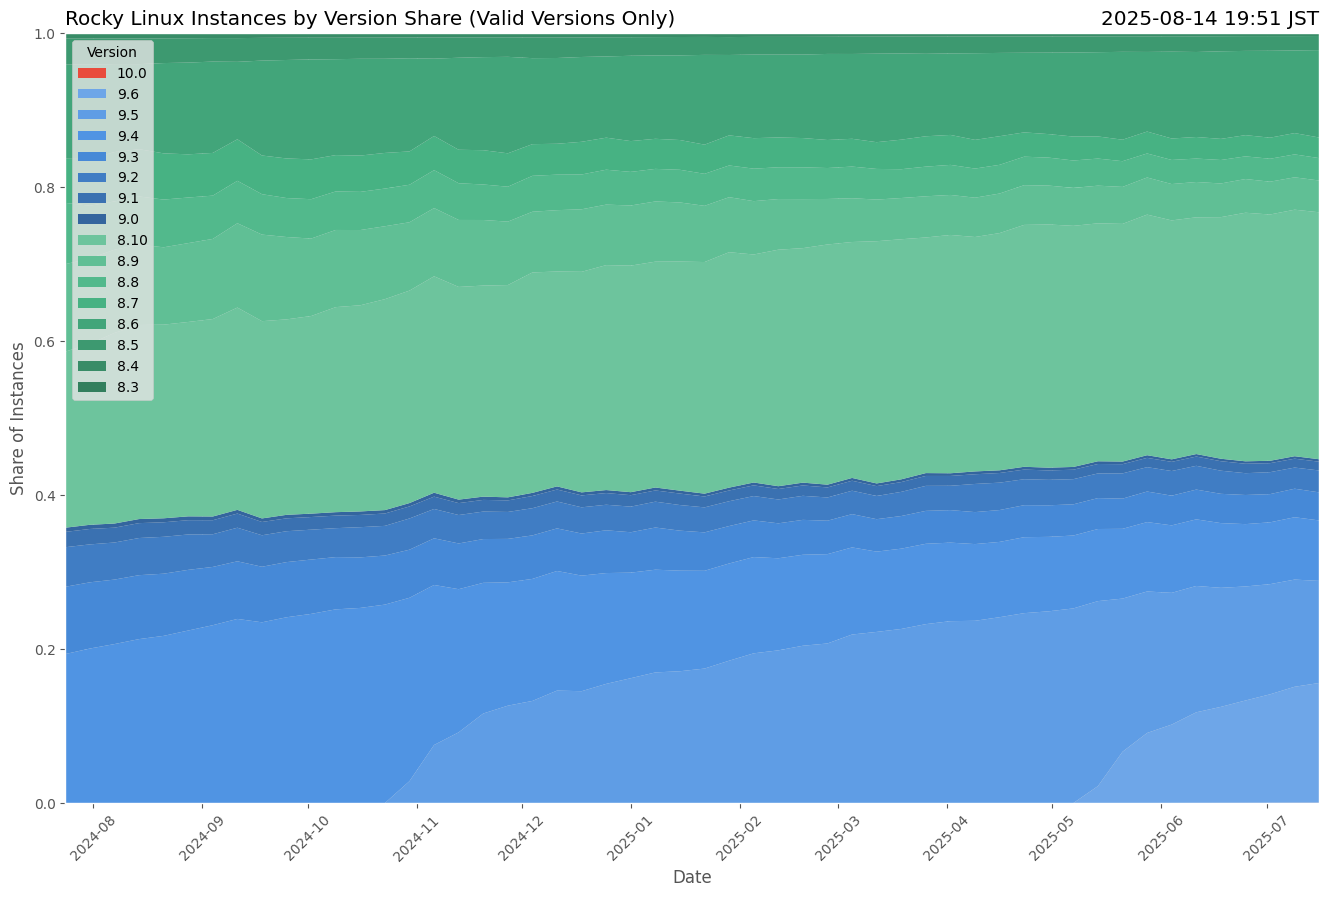

In [18]:
# Rocky Linux Instances by Version Share
df = filter_by_date(epel_df, STARTDATE)
df = filter_by_os_name(df, 'Rocky Linux')
df = filter_valid_rocky_versions(df)  # Filter to only valid versions
pt = create_pivot_table(df, index='week_end', columns='os_version')
pt = add_total_column(pt)

# Get available versions (sorted by version number)
versions = [col for col in pt.columns if col != 'total']
# Sort versions properly (8.x, then 9.x, then 10.x)
versions.sort(key=lambda x: (int(x.split('.')[0]), int(x.split('.')[1]) if '.' in x else 0), reverse=True)

# Generate colors programmatically based on major version themes
version_colors = generate_rocky_version_colors(versions)
colors_list = [version_colors[v] for v in versions]

fig, ax = setup_plot()
version_data = [pt[v]/pt['total'] for v in versions if v in pt.columns]
ax.stackplot(pt.index, *version_data, labels=versions, colors=colors_list)
setup_dates(ax)
add_title_and_timestamp('Rocky Linux Instances by Version Share (Valid Versions Only)')
plt.xlabel('Date')
plt.ylabel('Share of Instances')
plt.legend(loc='upper left', title='Version')
save_plot('rocky_by_version_share_area')

## Summary

This analysis provides comprehensive insights into Enterprise Linux distribution usage patterns using EPEL telemetry data. The refactored code structure makes it easier to:

- Add new visualizations
- Modify configuration settings
- Reuse data processing functions
- Maintain consistent plotting styles